In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

from torchvision import transforms
from torchvision import datasets

# Load data properly

Also define a function retrieving all dataloaders (training, validation and test).

In [ ]:
transformer = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
music_dataset = datasets.ImageFolder("./Data/genres_image_3s_filtered_new/", transform=transformer)

def get_dataloader(dataset, batch_size):
    """
        Return train validation and test dataloader
    """
    test_split = int(len(dataset)*0.85) 
    train_split = int(len(dataset)*0.7)

    # Shuffle dataset
    np.random.seed(123) # For reproductible results
    shuffled_idx = np.arange(len(dataset))
    np.random.shuffle(shuffled_idx)

    relevant_train_indices = shuffled_idx[:train_split]
    relevant_val_indices = shuffled_idx[train_split:test_split]
    relevant_test_indices = shuffled_idx[test_split:]

    # Create training DataLoader set
    train_sampler = torch.utils.data.SubsetRandomSampler(relevant_train_indices)
    train_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
                              
    # Create validation DataLoader set
    val_sampler = torch.utils.data.SubsetRandomSampler(relevant_val_indices)
    val_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=val_sampler)
                            
    # Create test DataLoader set
    test_sampler = torch.utils.data.SubsetRandomSampler(relevant_test_indices)
    test_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

    return train_loader, val_loader, test_loader

## Define useful functions to plot and save training curve

In [ ]:
def plot_training_curve(path):
    """ Plots the training curve for a model run, given the csv files
    containing the train/validation error/loss.

    Args:
        path: The base path of the csv files produced during training
    """
    train_acc = np.loadtxt("{}_train_acc.csv".format(path))
    val_acc = np.loadtxt("{}_val_acc.csv".format(path))
    train_loss = np.loadtxt("{}_train_loss.csv".format(path))
    val_loss = np.loadtxt("{}_val_loss.csv".format(path))
    plt.title("Train vs Validation Accuracy")
    n = len(train_acc) # number of epochs
    plt.plot(range(1,n+1), train_acc, label="Train")
    plt.plot(range(1,n+1), val_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(loc='best')
    # plt.savefig(path.replace(".", ",") + "_train_val_err")
    plt.show()

    plt.title("Train vs Validation Loss")
    plt.plot(range(1,n+1), train_loss, label="Train")
    plt.plot(range(1,n+1), val_loss, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc='best')
    # plt.savefig(path.replace(".", ",") + "_train_val_loss")
    plt.show()


def get_model_name(name, batch_size, learning_rate, epoch):
    """ Generate a name for the model consisting of all the hyperparameter values
    Args:
        name: name of the model
        batch_size: size of the batch used during training
        learning_rate: learning rate value used during training
        epoch: epoch value
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format( name,
                                                    batch_size,
                                                    learning_rate,
                                                    epoch)
    return path

# Define model

Define model class as well as train and evaluate functions, very useful to train easily our model by just tweaking the hyperparameters.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

In [5]:
def train(net, dataset, batch_size=1, learning_rate=0.01, num_epochs=10):
    train_loader, val_loader, _ = get_dataloader(dataset, batch_size=batch_size)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate, weight_decay=0.001) # weight decay ensures weights are not too high -> can prevent early overfitting

    train_acc = np.zeros(num_epochs)
    train_loss = np.zeros(num_epochs)
    val_acc = np.zeros(num_epochs)
    val_loss = np.zeros(num_epochs)
    ########################################################################
    # Train the network
    for epoch in range(num_epochs):
        total_train_loss = 0.0
        total_train_err = 0.0
        total_epoch = 0
        for i, data in enumerate(train_loader, 0):
            # Get the inputs
            inputs, labels = data[0].to(device), data[1].to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()
            # Forward pass, backward pass, and optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Calculate the statistics
            corr = (torch.argmax(outputs,1) != labels)
            total_train_err += int(corr.sum())
            total_train_loss += loss.item()
            total_epoch += len(labels)
        train_acc[epoch] = 1 - (float(total_train_err) / total_epoch)
        train_loss[epoch] = float(total_train_loss) / (i+1)
        val_acc[epoch], val_loss[epoch] = evaluate(net, val_loader, criterion)
        print(("Epoch {}: Train acc: {}, Train loss: {} |"+ "Val acc: {}, Val loss: {}").format(
                epoch + 1,
                train_acc[epoch],
                train_loss[epoch],
                val_acc[epoch],
                val_loss[epoch])
            )
    # Save the trained model to a file
    model_path = get_model_name(net.name, batch_size, learning_rate, epoch)
    torch.save(net.state_dict(), model_path)
    print('Finished Training')
    
    # Write the train/test loss/err into CSV file for plotting later
    np.savetxt("{}_train_acc.csv".format(model_path), train_acc)
    np.savetxt("{}_train_loss.csv".format(model_path), train_loss)
    np.savetxt("{}_val_acc.csv".format(model_path), val_acc)
    np.savetxt("{}_val_loss.csv".format(model_path), val_loss)

def evaluate(net, loader, criterion):
    """ Evaluate the network on the validation set.

    Args:
        loader: PyTorch data loader for the validation set
        criterion: The loss function
    Returns:
        acc: A scalar for the avg classification accuracy over the validation set
        loss: A scalar for the average loss function over the validation set
    """
    total_loss = 0.0
    total_err = 0.0
    total_epoch = 0
    for i, data in enumerate(loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        corr = (torch.argmax(outputs,1) != labels)
        total_err += int(corr.sum())
        total_loss += loss.item()
        total_epoch += len(labels)
    err = float(total_err) / total_epoch
    loss = float(total_loss) / (i + 1)
    acc = 1 - err
    return acc, loss

In [6]:
class MusicNet(nn.Module):
    def __init__(self, p_dropout_conv, p_dropout_fc):
        super(MusicNet, self).__init__()
        self.name = "musicnet"
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=3, stride=2, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=15, kernel_size=3, stride=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(15*15*21, 200)
        self.fc2 = nn.Linear(200, 10)  # Output layer with 10 classes
        self.dropout_conv = nn.Dropout2d(p=p_dropout_conv)
        self.dropout_fc = nn.Dropout(p=p_dropout_fc)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.dropout_conv(x) # dropout conv
        x = self.pool1(x)
        x = F.relu(self.conv2(x))
        x = self.dropout_conv(x) # dropout conv
        x = self.pool2(x)
        # print(x.shape)
        x = x.view(-1, 15*15*21)
        x = F.relu(self.fc1(x))
        x = self.dropout_fc(x) # dropout fc
        x = self.fc2(x)
        x = x.squeeze(1)
        return x

# Train CNN model

Epoch 1: Train acc: 0.2588033209275694, Train loss: 2.0084958718791945 |Val acc: 0.33333333333333337, Val loss: 1.8243633762319038
Epoch 2: Train acc: 0.3442599484683653, Train loss: 1.7822992687355983 |Val acc: 0.364061456245825, Val loss: 1.7162440634788352
Epoch 3: Train acc: 0.3947895791583166, Train loss: 1.661953363244392 |Val acc: 0.39612558450233804, Val loss: 1.6363118861583954
Epoch 4: Train acc: 0.41611795018608644, Train loss: 1.5901251176720885 |Val acc: 0.4048096192384769, Val loss: 1.581188678741455
Epoch 5: Train acc: 0.4567706842255941, Train loss: 1.5046821658469771 |Val acc: 0.4094856379425518, Val loss: 1.5470260965063216
Epoch 6: Train acc: 0.4675064414543373, Train loss: 1.4544496280417594 |Val acc: 0.4682698730794923, Val loss: 1.445011318998134
Epoch 7: Train acc: 0.49327225880332093, Train loss: 1.3877090634820668 |Val acc: 0.48162992651970604, Val loss: 1.4117978329354144
Epoch 8: Train acc: 0.5127397652447753, Train loss: 1.3431837988770716 |Val acc: 0.467601

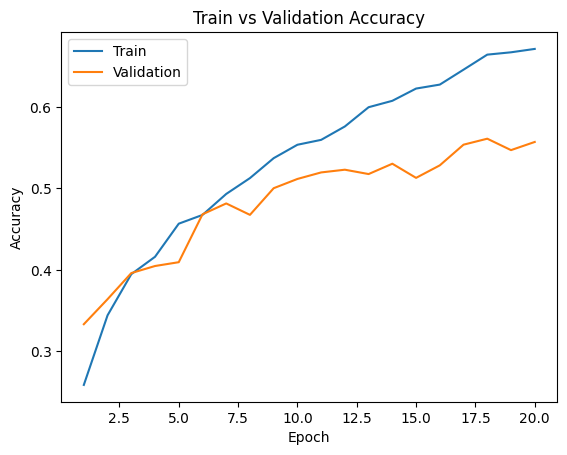

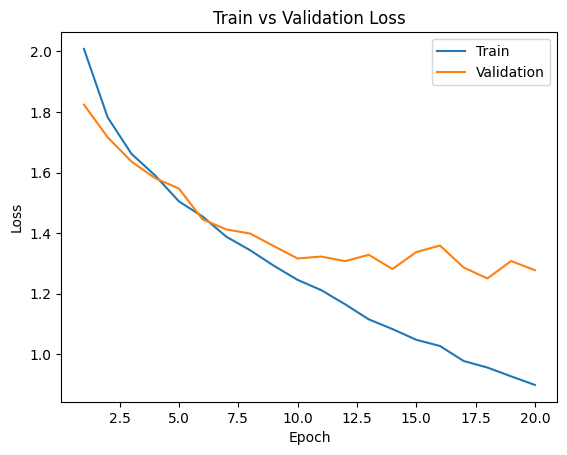

In [45]:
batch_size=32
learning_rate=0.0005
num_epochs=20
p_dropout_conv = 0.2
p_dropout_fc = 0.5

music_net = MusicNet(p_dropout_fc=p_dropout_fc, p_dropout_conv=p_dropout_conv)
music_net = music_net.to(device)

train(music_net, music_dataset, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs)

model_path = get_model_name("musicnet", batch_size, learning_rate, num_epochs-1)
plot_training_curve(model_path)

Epoch 1: Train acc: 0.2665330661322646, Train loss: 1.9715142098340122 |Val acc: 0.3279893119572478, Val loss: 1.8309448212385178
Epoch 2: Train acc: 0.34468937875751504, Train loss: 1.7727220047603953 |Val acc: 0.36272545090180364, Val loss: 1.6921408077081044
Epoch 3: Train acc: 0.3877755511022044, Train loss: 1.6763514334505254 |Val acc: 0.37541750167000665, Val loss: 1.654410680135091
Epoch 4: Train acc: 0.42055539650730034, Train loss: 1.5890335353938017 |Val acc: 0.42752171008684037, Val loss: 1.5712095151344936
Epoch 5: Train acc: 0.445319209848268, Train loss: 1.5130797635425222 |Val acc: 0.46359385437541745, Val loss: 1.4867268006006877
Epoch 6: Train acc: 0.47523618665903233, Train loss: 1.4312186501242898 |Val acc: 0.4649298597194389, Val loss: 1.44930300116539
Epoch 7: Train acc: 0.5073003149155454, Train loss: 1.3688544197516008 |Val acc: 0.47828991315965264, Val loss: 1.4336624046166737
Epoch 8: Train acc: 0.5206126538791869, Train loss: 1.3085741086439653 |Val acc: 0.499

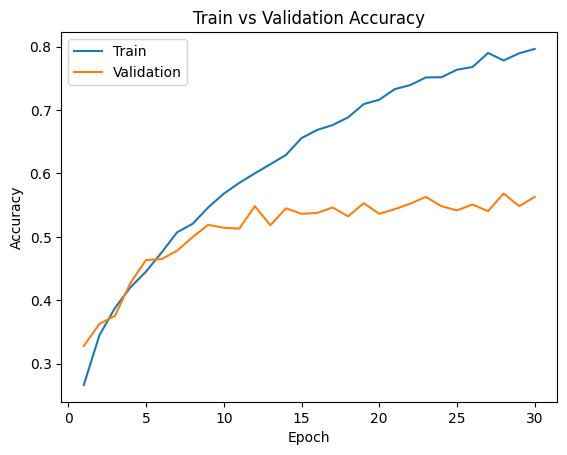

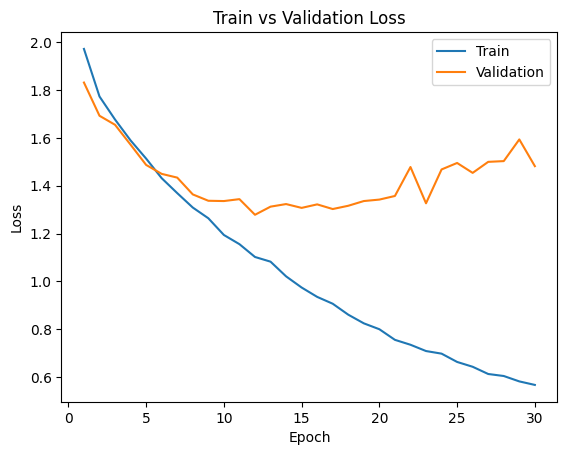

In [46]:
batch_size=64
learning_rate=0.0007
num_epochs=30
p_dropout_conv = 0.2
p_dropout_fc = 0.5

music_net = MusicNet(p_dropout_fc=p_dropout_fc, p_dropout_conv=p_dropout_conv)
music_net = music_net.to(device)

train(music_net, music_dataset, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs)

model_path = get_model_name("musicnet", batch_size, learning_rate, num_epochs-1)
plot_training_curve(model_path)

In [8]:
def testing(model_class, p_dropout_conv, p_dropout_fc, batch_size, lr, num_epochs, loader, criterion):
    # Load best model
    best_model = model_class(p_dropout_conv, p_dropout_fc)
    best_model = best_model.to(device)
    best_model_path = get_model_name(best_model.name, batch_size=batch_size, learning_rate=lr, epoch=num_epochs)
    best_model.load_state_dict(torch.load(best_model_path))

    # Evaluate
    test_acc, test_loss = evaluate(best_model, loader, criterion)
    print(f"Test accuracy: {test_acc} | Test loss: {test_loss}")

In [9]:
batch_size=64
learning_rate=0.0007
num_epochs=30
p_dropout_conv = 0.2
p_dropout_fc = 0.5

criterion = nn.CrossEntropyLoss()
_, _, test_loader = get_dataloader(music_dataset, batch_size=batch_size)

testing = testing(model_class=MusicNet,
                  p_dropout_conv=p_dropout_conv,
                  p_dropout_fc=p_dropout_fc,
                  batch_size=batch_size,
                  lr=learning_rate,
                  num_epochs=num_epochs - 1,
                  loader=test_loader,
                  criterion=criterion
                )

Test accuracy: 0.5233644859813085 | Test loss: 1.6659115850925446
